# Stock Price Classification

This is the Capstone project for The Data Incubator 2017 Fall Cohort developed by Ramin Tavassoli. 

## Abstract

The goal of this project was to create a model to classify whether the closing price of a stock falls above or below the opening price, given the opening price that day. This classification problem was modeled for 5 leading technology enterprises; Apple, Microsoft, Google, Tesla and Amazon. The feature space used included raw and engineered features acquired from Yahoo News "per day" stock data and Sentdex.com free tier "per day" sentiment data on these companies. The results were ...

## Methods

### Part 1: Getting and Wrangling Sentiment Data

The sentiment data on the 5 companies were acquired from http://sentdex.com. Using the APIs of 20 major news sources, sentdex.com renders an aggregate sentiment score in the range of -3 to +6 for each major company and public figure. In this analysis, -3 is as negative as +6 is positive. Sentdex, allocated a greater range for positive sentiments to capture the more complicated nuances of positive news. Sentdex has a free tier, daily dataset for a subset of their targeted institutions. We used their API to access this dataset. 

In [2]:
import requests
import pickle
import pandas as pd
import numpy as np 

Getting the sentiment data and serializing it. 

In [67]:
page = requests.get("http://sentdex.com/api/finance/sentiment-signals/sample")
dump = pickle.dump(page, open("dump.txt", "wb"))

In [68]:
load = pickle.load(open("dump.txt", "rb"))
data = (load.text).split('\n')
print(data[:10])

['date,symbol,sentiment_signal\r', '2012-10-15,AAPL,6\r', '2012-10-16,AAPL,2\r', '2012-10-17,AAPL,6\r', '2012-10-18,AAPL,6\r', '2012-10-19,AAPL,6\r', '2012-10-20,AAPL,6\r', '2012-10-21,AAPL,1\r', '2012-10-22,MSFT,6\r', '2012-10-22,GOOG,6\r']


Putting the data in a dataframe. 

In [69]:
from datetime import datetime as dt
import re

date = []
ticker = []
sentiment = []

for item in data:
	try:
		m = re.search('([0-9]*-[0-9]*-[0-9]*),([A-Z]*),(\-?[0-9])', item)
		date.append(m.group(1))
		ticker.append(m.group(2))
		sentiment.append(m.group(3))
	except:
		continue

df = pd.DataFrame({
	'date' : [dt.strptime(item,"%Y-%m-%d") for item in date],
	'ticker' : ticker,
	'sentiment' : sentiment
	})

Filtering by data; we use data from the beginning of 2013 to the end of 2015. 

In [70]:
df = df[df['date'] > '2012-12-31']
df = df[df['date'] < '2016-01-01']
df = df.reset_index(drop=True)
df = df.set_index('date')
df = df[df.index.dayofweek < 5]

In [71]:
print(df.head())

           sentiment ticker
date                       
2013-01-01         1    LOW
2013-01-01         1   ATVI
2013-01-01         2   AAPL
2013-01-01         3   SYMC
2013-01-01         6   PETS


Creating seperate dataframes for each company

In [72]:
df_sent_amazon = df[df['ticker'] == 'AMZN']
df_sent_apple = df[df['ticker'] == 'AAPL']
df_sent_goog = df[df['ticker'] == 'GOOG']
df_sent_tesla = df[df['ticker'] == 'TSLA']
df_sent_microsoft = df[df['ticker'] == 'MSFT']

In [73]:
df_sent_microsoft.head()

,sentiment,ticker
date,,
2013-01-01,4,MSFT
2013-01-02,2,MSFT
2013-01-03,1,MSFT
2013-01-04,-1,MSFT
2013-01-07,4,MSFT


### Part 2: Getting and Wrangling Stock Data

Now we get the stock data for the aforementioned data range.

In [74]:
import datetime as dt
start = dt.datetime(2012,12,31)
end = dt.datetime(2016,1,1)

Note: If the code below throws a "Remote" error, run it until you acquire the data. Sometimes the pipe is not correctly established. 

In [75]:
import pandas_datareader.data as web

df_data_google = web.DataReader('GOOG','yahoo', start, end)
df_data_tesla = web.DataReader('TSLA','yahoo', start, end)
df_data_microsoft = web.DataReader('MSFT','yahoo', start, end)
df_data_amazon = web.DataReader('AMZN','yahoo', start, end)
df_data_aaple = web.DataReader('AAPL','yahoo', start, end)

In [76]:
df_data_amazon.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-31,243.750000,252.410004,242.750000,250.869995,250.869995,3419000
2013-01-02,256.079987,258.100006,253.259995,257.309998,257.309998,3271000
2013-01-03,257.269989,260.880005,256.369995,258.480011,258.480011,2750900
2013-01-04,257.579987,259.799988,256.649994,259.149994,259.149994,1874200
2013-01-07,262.970001,269.730011,262.670013,268.459991,268.459991,4910000


### Part 3: Feature Extraction and Engineering

In this part of the project, We joined the sentiment and the stock dataframes on the date index and engineered the following feature space.
- index : date
- Ticker : Stock ticker
- Open-Scaled : MinMax Scaled Open Price.
- Yesterday_Sentiment : Sentiment score for yesterday
- Overnight Price Change : (Today's Open - Yesterday's Close)/Yesterday's Close
- Lagging Closing Price Change : (Yesterday's Close - Two days ago Close)/Two days ago Close
- Lagging Volume Change : (Yesterday's Volume Traded - Two days ago Volume Traded)/Two days ago Volume Traded
- Lagging Sentiment Trend = Yesterday's Sentiment - Two days ago Sentiment
- Target : 0 if Today Close < Today Open and 1 if Today Close > Today Open

We retrieve the serialized dataframes from AWS S3:

In [11]:
!aws s3 sync s3://tdi-dataframes/ . --include "*"

fatal error: An error occurred (RequestTimeTooSkewed) when calling the ListObjects operation: The difference between the request time and the current time is too large.


In [12]:
AMZN = pickle.load(open('AMAZON_DF.txt', 'rb'))
AAPL = pickle.load(open('APPLE_DF.txt', 'rb'))
GOOG = pickle.load(open('GOOGLE_DF.txt', 'rb'))
MSFT = pickle.load(open('MICROSOFT_DF.txt', 'rb'))
TSLA = pickle.load(open('TESLA_DF.txt', 'rb'))

### Part 4: Data Visualization and Exploratory Analysis

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import dates as d
from matplotlib import style

In [80]:
!aws s3 sync s3://tdi-plotdata/ . --include "*"

# Results

Once the dataframes for the companies were constructed, RandomForest, Support Vector Machine and Recurrent Neural Nets were applied to model the data. Only the report for the first company is verbose. Identical procedure is followed for the rest.

## Google

In [81]:
GOOG.head()

,Ticker,Open_Scaled,Yesterday_Sentiment,Overnight Price Change(%),Lagging Closing Price Change(%),Lagging Volume Change(%),Lagging Sentiment Trend,Target
2013-01-04,GOOG,0.028743,-3.0,0.007835,0.000581,-0.087772,-4.0,1
2013-01-07,GOOG,0.035859,-1.0,-0.003415,0.019760,0.192071,2.0,0
2013-01-08,GOOG,0.035964,-1.0,0.001075,-0.004363,-0.400859,0.0,0
2013-01-09,GOOG,0.032155,6.0,-0.001405,-0.001973,0.012302,7.0,1
2013-01-10,GOOG,0.044454,3.0,0.006381,0.006573,0.208009,-3.0,0


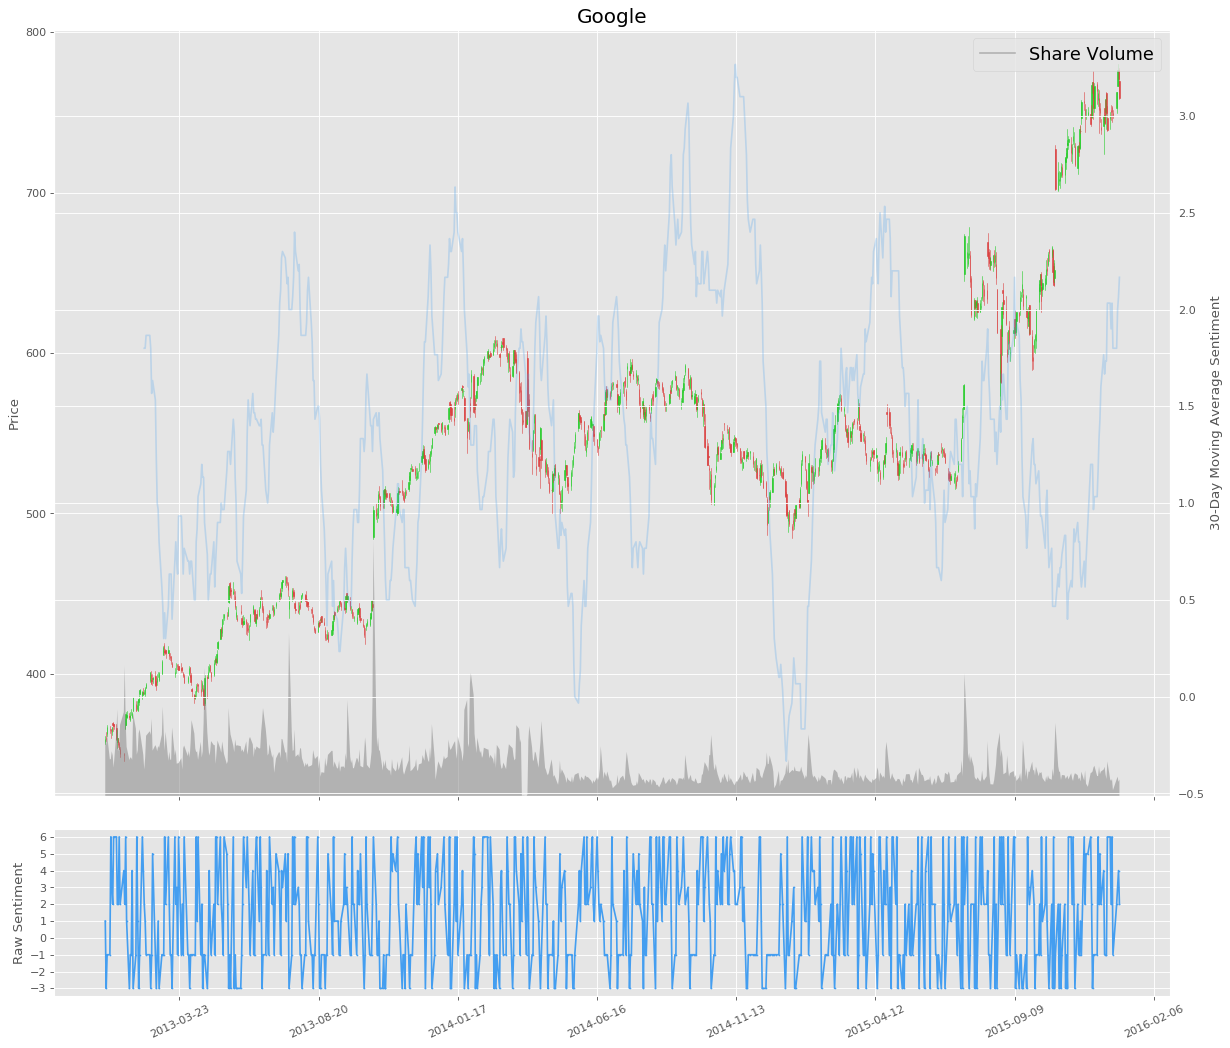

In [82]:
plt.style.use('ggplot')

def candlestick(stock):
	fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

	ax_1 = plt.subplot2grid((5,1), (0,0), rowspan=4, colspan=1)

	plt.title(stock, fontsize=18)
	plt.ylabel('Price')
	ax_1v2 = ax_1.twinx()
	ax_1v3 = ax_1.twinx()
	ax_1v3.yaxis.set_label_position('right')
	plt.ylabel('30-Day Moving Average Sentiment')

	ax_2 = plt.subplot2grid((5,1), (4,0), rowspan=1, colspan=1, sharex= ax_1)
	plt.ylabel('Raw Sentiment')
	df = pickle.load(open('goog.txt', 'rb'))

	#first graph

	ax_1.tick_params(
		axis = 'y',
		which = 'both',
		right ='off',
		)

	ohlc = []
	for i in range(df.shape[0]):
	    ohlc.append([d.date2num(df.index[i]), df['Open'][i], df['High'][i], df['Low'][i], df['Close'][i]])

	candlestick_ohlc(ax_1, ohlc, width=0.4, colorup='#22cc26', colordown='#db3f3f')



	#second graph
	sent_date = []
	sent_value = []
	for i in range(df.shape[0]):
		sent_date.append(d.date2num(df.index[i]))
		sent_value.append(df['sentiment'][i])
	ax_2.plot(sent_date, sent_value,'s-', color='#449EF0', markersize='0.5')
	ax_2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
	ax_2.xaxis.set_major_locator(mticker.MaxNLocator(10))
	for label in ax_2.xaxis.get_ticklabels():
		label.set_rotation(25)
	ax_2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=10 ,prune='upper'))
	
	#overlapping graph_1
	ax_1v2.tick_params(
		axis = 'y',
		which = 'both',
		right ='off',
		left='off'
		)
	vol =[]
	for i in range(df.shape[0]):
		vol.append(df['Volume'][i])

	vol_date = sent_date
	ax_1v2.plot([],[], color="#808080", alpha=0.5, label="Share Volume")
	ax_1v2.fill_between(vol_date, 0, vol, facecolor="#808080", alpha=0.5)
	ax_1v2.yaxis.set_ticklabels([])
	ax_1v2.grid(False)
	ax_1v2.set_ylim(0, 3*max(vol))


	#overlapping_sent_moving_avg:
	ax_1v3.tick_params(
		axis = 'y',
		which = 'both',
		left='off',
		right = 'off'
		)
	ma = moving_average(sent_value, 30)
	date = sent_date[29:]
	ax_1v3.plot(date, ma, color='#449EF0', alpha=0.25, label="30 Day Moving AVG")

	ax_1v2.legend()
	leg = ax_1v2.legend(prop={'size': 16})
	leg.get_frame()

	plt.setp(ax_1.get_xticklabels(), visible=False)
	plt.show()



def moving_average(values, window):
	weights = np.repeat(1.0, window)/window
	smas = np.convolve(values, weights, 'valid')
	return smas

# df_ = pickle.load(open('amzn_sent.txt', 'rb'))
# df_sent = df_[df_['ticker'] == 'AMZN']['sentiment'][0]
# print(df_sent)
candlestick('Google')

### RandomForest

In [83]:
import numpy as np
features = np.asarray(GOOG.drop(['Ticker','Target'], 1))
target = np.asarray(GOOG['Target'])

ANOVA F-tests was used as a preprocessing step to find 3 most valuable features (those with the highest variance)

In [84]:
#feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

features_new = SelectKBest(f_classif,k=3).fit_transform(features, target)

In [85]:
features_new[:10]

array([[ -3.00000000e+00,   7.83506500e-03,  -8.77724563e-02],
       [ -1.00000000e+00,  -3.41478150e-03,   1.92071145e-01],
       [ -1.00000000e+00,   1.07521895e-03,  -4.00859279e-01],
       [  6.00000000e+00,  -1.40457070e-03,   1.23015992e-02],
       [  3.00000000e+00,   6.38107890e-03,   2.08008536e-01],
       [  2.00000000e+00,   7.01330309e-04,  -9.33827318e-02],
       [  6.00000000e+00,  -4.04062691e-03,  -2.99883630e-01],
       [  6.00000000e+00,  -5.41995569e-03,   1.22844994e+00],
       [  2.00000000e+00,  -3.48993788e-03,   3.71431049e-01],
       [  2.00000000e+00,   3.52355091e-03,  -4.84828554e-01]])

The important features are Yesterday_Sentiment, Overnight Price Change(%) and Lagging Volume Change(%)

Test-train split:

In [86]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
features_new, target, test_size = 0.2, random_state = 0)

cross validation step:

In [87]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

range_ = range(3,10)
k_scores = dict()
for k in range_:
    clf = RandomForestClassifier(max_depth = k)
    scores = cross_val_score(clf, features_new, target, cv = 10, scoring = "r2")
    k_scores[scores.mean()] = k

best_k = k_scores[max(k_scores)]

In [88]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = best_k)
clf.fit(X_train, y_train)
clf.feature_importances_

array([ 0.11345625,  0.43916147,  0.44738228])

The least important feature is the sentiment data.

In [89]:
GOOG_RF = clf.score(X_test, y_test)

In [90]:
GOOG_RF

0.46357615894039733

### Support Vector Classifier - rbf kernel

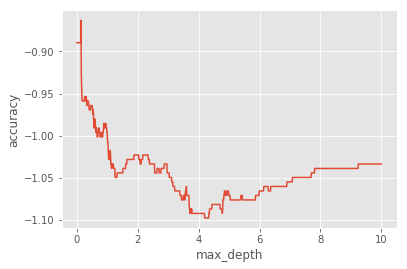

In [91]:
from sklearn import svm
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

range_ = [x/100+0.01 for x in range(1000)]

k_scores = []
for k in range_:
    clf_ = svm.SVC(kernel='rbf', C=k)
    scores = cross_val_score(clf_, features_new, target, cv = 3, scoring = "r2")
    k_scores.append(scores.mean())

plt.plot(range_,k_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

The cost parameter (C) in an SVM places an upper bound on the norm of the weights. It is a regularisation parameter, where lower means more regularised and simpler model. In our case, the lowest C yields the greatest accuracy indicating that linear models may work best to model this company. To test this hypothesis, LinearSVC models for all 5 companies were trained, but they all fell short of their rbf kernel SVC counterparts.  

In [92]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=0.01)
clf.fit(X_train, y_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [93]:
GOOG_SVC_rbf = clf.score(X_test,y_test)

In [94]:
GOOG_SVC_rbf

0.51655629139072845

## Microsoft

In [95]:
MSFT.head()

,Ticker,Open_Scaled,Yesterday_Sentiment,Overnight Price Change(%),Lagging Closing Price Change(%),Lagging Volume Change(%),Lagging Sentiment Trend,Target
2013-01-04,MSFT,0.026017,1.0,0.000734,-0.013396,-0.087050,-1.0,0
2013-01-07,MSFT,0.009340,-1.0,0.001122,-0.018716,0.087519,-2.0,0
2013-01-08,MSFT,0.008672,4.0,0.002248,-0.001870,-0.293419,5.0,0
2013-01-09,MSFT,0.007672,2.0,0.006403,-0.005245,0.204598,-2.0,0
2013-01-10,MSFT,0.005337,1.0,-0.001873,0.005650,0.097192,-1.0,0


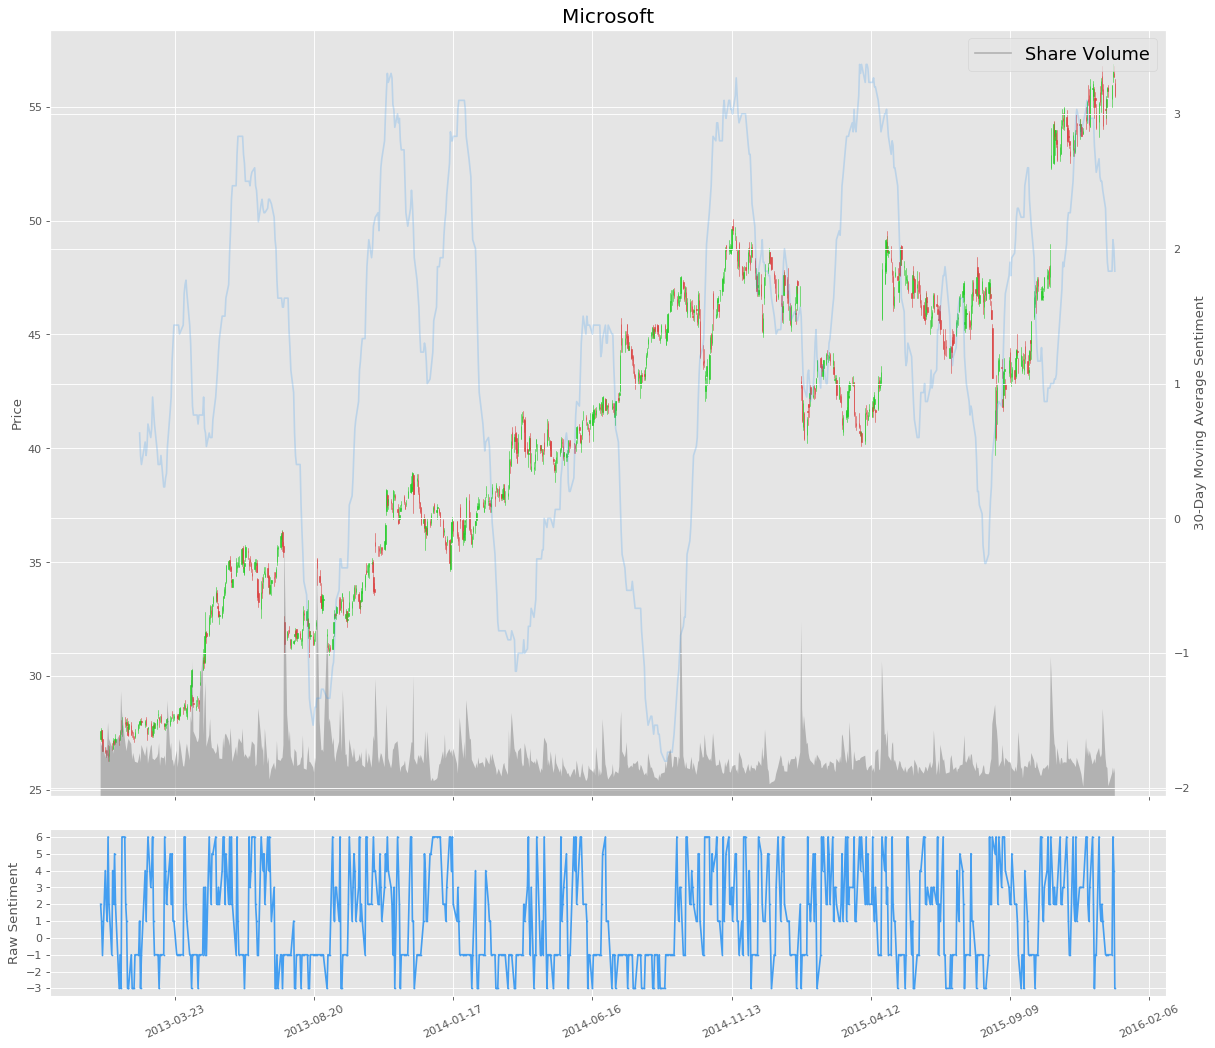

In [96]:
plt.style.use('ggplot')

def candlestick(stock):
	fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

	ax_1 = plt.subplot2grid((5,1), (0,0), rowspan=4, colspan=1)

	plt.title(stock, fontsize=18)
	plt.ylabel('Price')
	ax_1v2 = ax_1.twinx()
	ax_1v3 = ax_1.twinx()
	ax_1v3.yaxis.set_label_position('right')
	plt.ylabel('30-Day Moving Average Sentiment')

	ax_2 = plt.subplot2grid((5,1), (4,0), rowspan=1, colspan=1, sharex= ax_1)
	plt.ylabel('Raw Sentiment')
	df = pickle.load(open('msft.txt', 'rb'))

	#first graph

	ax_1.tick_params(
		axis = 'y',
		which = 'both',
		right ='off',
		)

	ohlc = []
	for i in range(df.shape[0]):
	    ohlc.append([d.date2num(df.index[i]), df['Open'][i], df['High'][i], df['Low'][i], df['Close'][i]])

	candlestick_ohlc(ax_1, ohlc, width=0.4, colorup='#22cc26', colordown='#db3f3f')



	#second graph
	sent_date = []
	sent_value = []
	for i in range(df.shape[0]):
		sent_date.append(d.date2num(df.index[i]))
		sent_value.append(df['sentiment'][i])
	ax_2.plot(sent_date, sent_value,'s-', color='#449EF0', markersize='0.5')
	ax_2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
	ax_2.xaxis.set_major_locator(mticker.MaxNLocator(10))
	for label in ax_2.xaxis.get_ticklabels():
		label.set_rotation(25)
	ax_2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=10 ,prune='upper'))
	
	#overlapping graph_1
	ax_1v2.tick_params(
		axis = 'y',
		which = 'both',
		right ='off',
		left='off'
		)
	vol =[]
	for i in range(df.shape[0]):
		vol.append(df['Volume'][i])

	vol_date = sent_date
	ax_1v2.plot([],[], color="#808080", alpha=0.5, label="Share Volume")
	ax_1v2.fill_between(vol_date, 0, vol, facecolor="#808080", alpha=0.5)
	ax_1v2.yaxis.set_ticklabels([])
	ax_1v2.grid(False)
	ax_1v2.set_ylim(0, 3*max(vol))


	#overlapping_sent_moving_avg:
	ax_1v3.tick_params(
		axis = 'y',
		which = 'both',
		left='off',
		right = 'off'
		)
	ma = moving_average(sent_value, 30)
	date = sent_date[29:]
	ax_1v3.plot(date, ma, color='#449EF0', alpha=0.25, label="30 Day Moving AVG")

	ax_1v2.legend()
	leg = ax_1v2.legend(prop={'size': 16})
	leg.get_frame()

	plt.setp(ax_1.get_xticklabels(), visible=False)
	plt.show()



def moving_average(values, window):
	weights = np.repeat(1.0, window)/window
	smas = np.convolve(values, weights, 'valid')
	return smas

# df_ = pickle.load(open('amzn_sent.txt', 'rb'))
# df_sent = df_[df_['ticker'] == 'AMZN']['sentiment'][0]
# print(df_sent)
candlestick('Microsoft')

### Random Forest

In [6]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import cross_validation

features = np.asarray(MSFT.drop(['Ticker','Target'], 1))
target = np.asarray(MSFT['Target'])

#feature selection
features_new = SelectKBest(f_classif,k=3).fit_transform(features, target)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
features_new, target, test_size = 0.2, random_state = 0)

from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

range_ = range(2,10)
k_scores = dict()
for k in range_:
    clf = RandomForestClassifier(max_depth = k)
    scores = cross_val_score(clf, features_new, target, cv = 10, scoring = "r2")
    k_scores[scores.mean()] = k

best_k = k_scores[max(k_scores)]


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = best_k)
clf.fit(X_train, y_train)

MSFT_RF = clf.score(X_test, y_test)
MSFT_RF, clf.feature_importances_, features_new


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(0.60264900662251653,
 array([ 0.37430685,  0.06729223,  0.55840092]),
 array([[ 0.02601734,  1.        , -0.0870503 ],
        [ 0.00933956, -1.        ,  0.08751946],
        [ 0.00867245,  4.        , -0.29341922],
        ..., 
        [ 0.993996  , -1.        ,  1.26729363],
        [ 1.        ,  6.        ,  0.27806249],
        [ 0.98565711,  4.        , -0.21733126]]))

For Microsoft, the opening price and the lagging volume change(%) are the dominant features. 

### Support Vector Machine - rbf kernel

In [14]:
from sklearn import svm
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

range_ = [x/100+0.01 for x in range(1000)]

features = np.asarray(MSFT.drop(['Ticker','Target'], 1))
target = np.asarray(MSFT['Target'])

#feature selection
features_new = SelectKBest(f_classif,k=3).fit_transform(features, target)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
features_new, target, test_size = 0.2, random_state = 0)

k_scores = dict()
for k in range_:
    clf_ = svm.SVC(kernel='rbf', C=k)
    scores = cross_val_score(clf_, features_new, target, cv = 3, scoring = "r2")
    k_scores[scores.mean()] = k

best_k = k_scores[max(k_scores)]

clf_ = svm.SVC(kernel='rbf', C=best_k)
clf_.fit(X_train, y_train)
MSFT_SVC_rbf = clf.score(X_test,y_test)
MSFT_SVC_rbf

0.58278145695364236

## Amazon

In [99]:
AMZN.head()

,Ticker,Open_Scaled,Yesterday_Sentiment,Overnight Price Change(%),Lagging Closing Price Change(%),Lagging Volume Change(%),Lagging Sentiment Trend,Target
2013-01-04,AMZN,0.019506,-3.0,-0.003482,0.004547,-0.159003,-2.0,1
2013-01-07,AMZN,0.031674,-3.0,0.014741,0.002592,-0.318696,0.0,1
2013-01-08,AMZN,0.040930,-1.0,-0.005178,0.035925,1.619784,2.0,0
2013-01-09,AMZN,0.043414,4.0,0.006720,-0.007748,-0.386823,5.0,0
2013-01-10,AMZN,0.044249,2.0,0.008222,-0.000113,-0.247484,-2.0,0


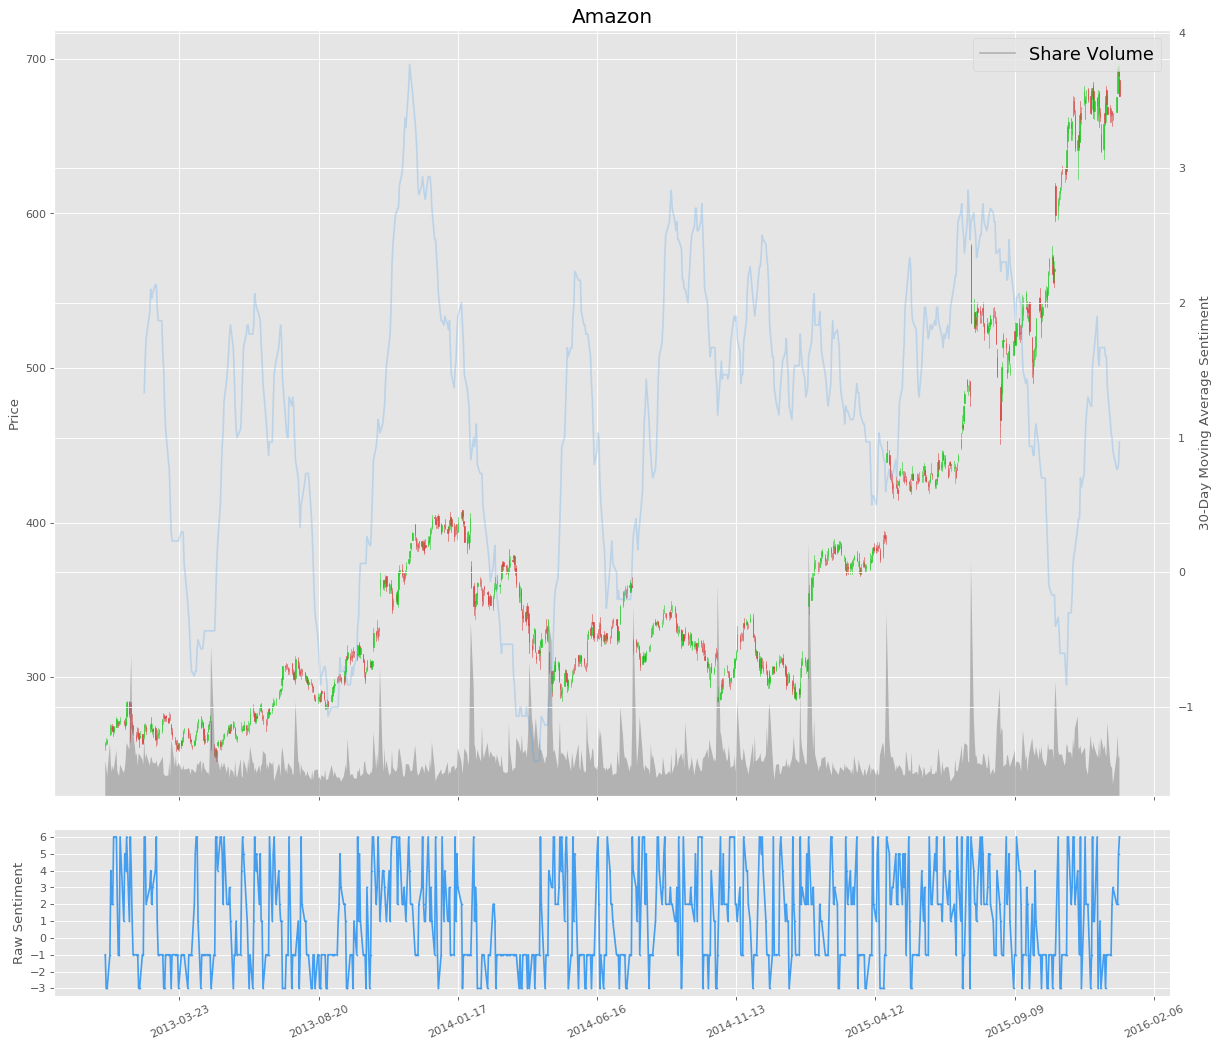

In [100]:
plt.style.use('ggplot')

def candlestick(stock):
	fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

	ax_1 = plt.subplot2grid((5,1), (0,0), rowspan=4, colspan=1)

	plt.title(stock, fontsize=18)
	plt.ylabel('Price')
	ax_1v2 = ax_1.twinx()
	ax_1v3 = ax_1.twinx()
	ax_1v3.yaxis.set_label_position('right')
	plt.ylabel('30-Day Moving Average Sentiment')

	ax_2 = plt.subplot2grid((5,1), (4,0), rowspan=1, colspan=1, sharex= ax_1)
	plt.ylabel('Raw Sentiment')
	df = pickle.load(open('amzn.txt', 'rb'))

	#first graph

	ax_1.tick_params(
		axis = 'y',
		which = 'both',
		right ='off',
		)

	ohlc = []
	for i in range(df.shape[0]):
	    ohlc.append([d.date2num(df.index[i]), df['Open'][i], df['High'][i], df['Low'][i], df['Close'][i]])

	candlestick_ohlc(ax_1, ohlc, width=0.4, colorup='#22cc26', colordown='#db3f3f')



	#second graph
	sent_date = []
	sent_value = []
	for i in range(df.shape[0]):
		sent_date.append(d.date2num(df.index[i]))
		sent_value.append(df['sentiment'][i])
	ax_2.plot(sent_date, sent_value,'s-', color='#449EF0', markersize='0.5')
	ax_2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
	ax_2.xaxis.set_major_locator(mticker.MaxNLocator(10))
	for label in ax_2.xaxis.get_ticklabels():
		label.set_rotation(25)
	ax_2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=10 ,prune='upper'))
	
	#overlapping graph_1
	ax_1v2.tick_params(
		axis = 'y',
		which = 'both',
		right ='off',
		left='off'
		)
	vol =[]
	for i in range(df.shape[0]):
		vol.append(df['Volume'][i])

	vol_date = sent_date
	ax_1v2.plot([],[], color="#808080", alpha=0.5, label="Share Volume")
	ax_1v2.fill_between(vol_date, 0, vol, facecolor="#808080", alpha=0.5)
	ax_1v2.yaxis.set_ticklabels([])
	ax_1v2.grid(False)
	ax_1v2.set_ylim(0, 3*max(vol))


	#overlapping_sent_moving_avg:
	ax_1v3.tick_params(
		axis = 'y',
		which = 'both',
		left='off',
		right = 'off'
		)
	ma = moving_average(sent_value, 30)
	date = sent_date[29:]
	ax_1v3.plot(date, ma, color='#449EF0', alpha=0.25, label="30 Day Moving AVG")

	ax_1v2.legend()
	leg = ax_1v2.legend(prop={'size': 16})
	leg.get_frame()

	plt.setp(ax_1.get_xticklabels(), visible=False)
	plt.show()



def moving_average(values, window):
	weights = np.repeat(1.0, window)/window
	smas = np.convolve(values, weights, 'valid')
	return smas

# df_ = pickle.load(open('amzn_sent.txt', 'rb'))
# df_sent = df_[df_['ticker'] == 'AMZN']['sentiment'][0]
# print(df_sent)
candlestick('Amazon')

### Random Forest

In [101]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import cross_validation

features = np.asarray(MSFT.drop(['Ticker','Target'], 1))
target = np.asarray(MSFT['Target'])

#feature selection
features_new = SelectKBest(f_classif,k=3).fit_transform(features, target)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
features_new, target, test_size = 0.2, random_state = 0)

from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

range_ = range(2,10)
k_scores = dict()
for k in range_:
    clf = RandomForestClassifier(max_depth = k)
    scores = cross_val_score(clf, features_new, target, cv = 10, scoring = "r2")
    k_scores[scores.mean()] = k

best_k = k_scores[max(k_scores)]


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = best_k)
clf.fit(X_train, y_train)

AMZN_RF = clf.score(X_test, y_test)
AMZN_RF, clf.feature_importances_, features_new

(0.54966887417218546,
 array([ 0.41806461,  0.14767905,  0.43425634]),
 array([[ 0.02601734,  1.        , -0.0870503 ],
        [ 0.00933956, -1.        ,  0.08751946],
        [ 0.00867245,  4.        , -0.29341922],
        ..., 
        [ 0.993996  , -1.        ,  1.26729363],
        [ 1.        ,  6.        ,  0.27806249],
        [ 0.98565711,  4.        , -0.21733126]]))

### Support Vector Machine - rbf kernel

In [102]:
from sklearn import svm
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

range_ = [x/100+0.01 for x in range(1000)]

k_scores = dict()
for k in range_:
    clf_ = svm.SVC(kernel='rbf', C=k)
    scores = cross_val_score(clf_, features_new, target, cv = 3, scoring = "r2")
    k_scores[scores.mean()] = k

best_k = k_scores[max(k_scores)]

clf = svm.SVC(kernel='rbf', C=best_k)
clf.fit(X_train, y_train)
AMZN_SVC_rbf = clf.score(X_test,y_test)
AMZN_SVC_rbf

0.58278145695364236

## Apple

In [103]:
AAPL.head()

,Ticker,Open_Scaled,Yesterday_Sentiment,Overnight Price Change(%),Lagging Closing Price Change(%),Lagging Volume Change(%),Lagging Sentiment Trend,Target
2013-01-04,AAPL,0.269318,6.0,-0.009463,-0.012622,-0.370287,1.0,0
2013-01-07,AAPL,0.242259,6.0,-0.009488,-0.027855,0.683831,0.0,1
2013-01-08,AAPL,0.255291,1.0,0.010135,-0.005882,-0.185379,-5.0,0
2013-01-09,AAPL,0.243163,6.0,-0.005349,0.002691,-0.052564,5.0,0
2013-01-10,AAPL,0.254098,6.0,0.022143,-0.015629,-0.111406,0.0,0


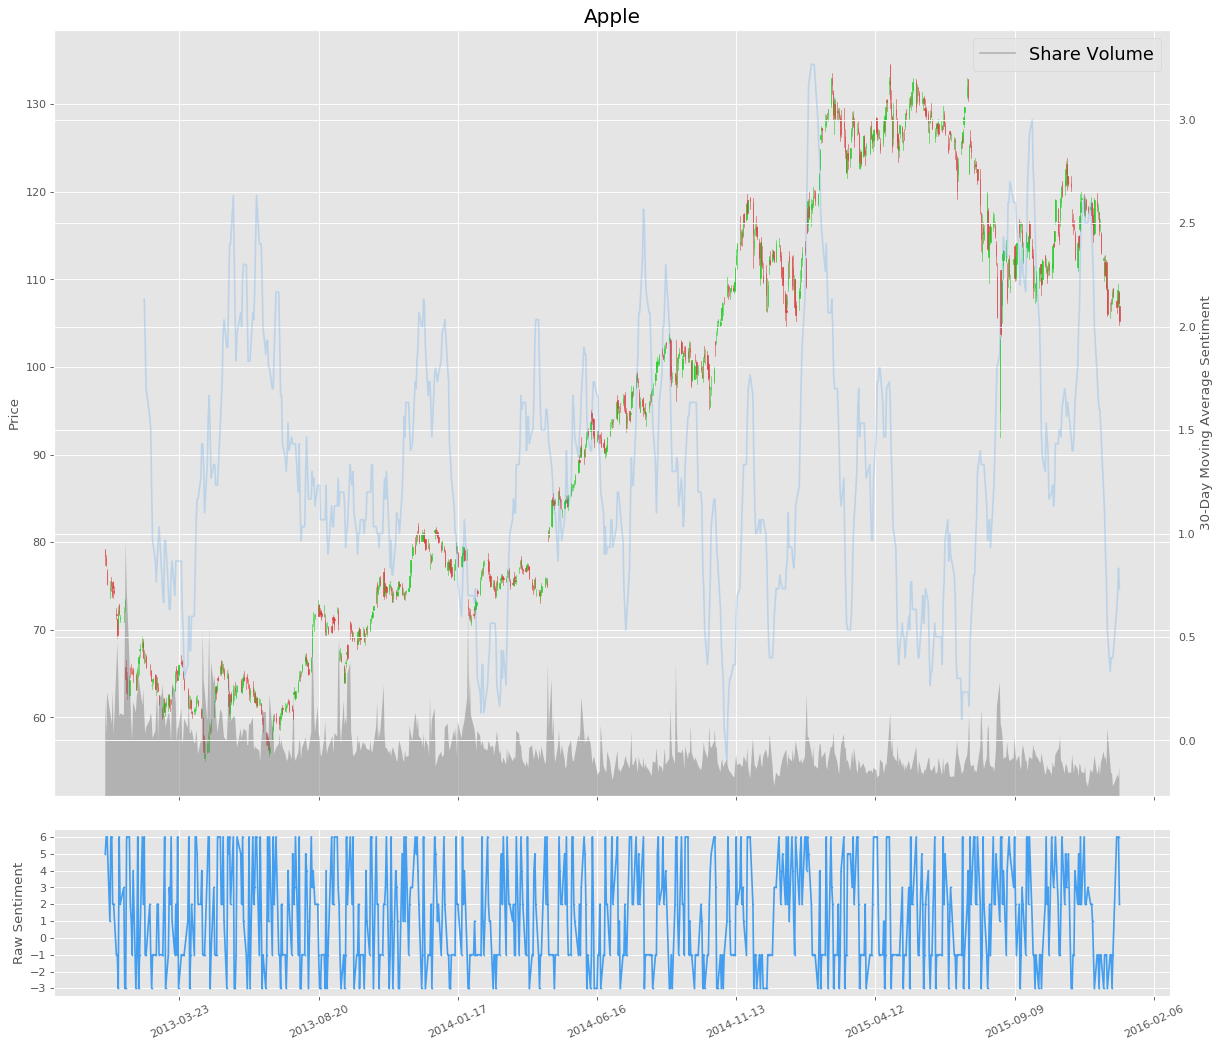

In [104]:
plt.style.use('ggplot')

def candlestick(stock):
	fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

	ax_1 = plt.subplot2grid((5,1), (0,0), rowspan=4, colspan=1)

	plt.title(stock, fontsize=18)
	plt.ylabel('Price')
	ax_1v2 = ax_1.twinx()
	ax_1v3 = ax_1.twinx()
	ax_1v3.yaxis.set_label_position('right')
	plt.ylabel('30-Day Moving Average Sentiment')

	ax_2 = plt.subplot2grid((5,1), (4,0), rowspan=1, colspan=1, sharex= ax_1)
	plt.ylabel('Raw Sentiment')
	df = pickle.load(open('aapl.txt', 'rb'))

	#first graph

	ax_1.tick_params(
		axis = 'y',
		which = 'both',
		right ='off',
		)

	ohlc = []
	for i in range(df.shape[0]):
	    ohlc.append([d.date2num(df.index[i]), df['Open'][i], df['High'][i], df['Low'][i], df['Close'][i]])

	candlestick_ohlc(ax_1, ohlc, width=0.4, colorup='#22cc26', colordown='#db3f3f')



	#second graph
	sent_date = []
	sent_value = []
	for i in range(df.shape[0]):
		sent_date.append(d.date2num(df.index[i]))
		sent_value.append(df['sentiment'][i])
	ax_2.plot(sent_date, sent_value,'s-', color='#449EF0', markersize='0.5')
	ax_2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
	ax_2.xaxis.set_major_locator(mticker.MaxNLocator(10))
	for label in ax_2.xaxis.get_ticklabels():
		label.set_rotation(25)
	ax_2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=10 ,prune='upper'))
	
	#overlapping graph_1
	ax_1v2.tick_params(
		axis = 'y',
		which = 'both',
		right ='off',
		left='off'
		)
	vol =[]
	for i in range(df.shape[0]):
		vol.append(df['Volume'][i])

	vol_date = sent_date
	ax_1v2.plot([],[], color="#808080", alpha=0.5, label="Share Volume")
	ax_1v2.fill_between(vol_date, 0, vol, facecolor="#808080", alpha=0.5)
	ax_1v2.yaxis.set_ticklabels([])
	ax_1v2.grid(False)
	ax_1v2.set_ylim(0, 3*max(vol))


	#overlapping_sent_moving_avg:
	ax_1v3.tick_params(
		axis = 'y',
		which = 'both',
		left='off',
		right = 'off'
		)
	ma = moving_average(sent_value, 30)
	date = sent_date[29:]
	ax_1v3.plot(date, ma, color='#449EF0', alpha=0.25, label="30 Day Moving AVG")

	ax_1v2.legend()
	leg = ax_1v2.legend(prop={'size': 16})
	leg.get_frame()

	plt.setp(ax_1.get_xticklabels(), visible=False)
	plt.show()



def moving_average(values, window):
	weights = np.repeat(1.0, window)/window
	smas = np.convolve(values, weights, 'valid')
	return smas

# df_ = pickle.load(open('amzn_sent.txt', 'rb'))
# df_sent = df_[df_['ticker'] == 'AMZN']['sentiment'][0]
# print(df_sent)
candlestick('Apple')

### Random Forest

In [105]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import cross_validation

features = np.asarray(MSFT.drop(['Ticker','Target'], 1))
target = np.asarray(MSFT['Target'])

#feature selection
features_new = SelectKBest(f_classif,k=3).fit_transform(features, target)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
features_new, target, test_size = 0.2, random_state = 0)

from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

range_ = range(2,10)
k_scores = dict()
for k in range_:
    clf = RandomForestClassifier(max_depth = k)
    scores = cross_val_score(clf, features_new, target, cv = 10, scoring = "r2")
    k_scores[scores.mean()] = k

best_k = k_scores[max(k_scores)]


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = best_k)
clf.fit(X_train, y_train)

AAPL_RF = clf.score(X_test, y_test)
AAPL_RF, clf.feature_importances_, features_new

(0.58278145695364236,
 array([ 0.28864131,  0.28542098,  0.42593771]),
 array([[ 0.02601734,  1.        , -0.0870503 ],
        [ 0.00933956, -1.        ,  0.08751946],
        [ 0.00867245,  4.        , -0.29341922],
        ..., 
        [ 0.993996  , -1.        ,  1.26729363],
        [ 1.        ,  6.        ,  0.27806249],
        [ 0.98565711,  4.        , -0.21733126]]))

### Support Vector Machine - rbf kernel

In [106]:
from sklearn import svm
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

range_ = [x/100+0.01 for x in range(1000)]

features = np.asarray(MSFT.drop(['Ticker','Target'], 1))
target = np.asarray(MSFT['Target'])

#feature selection
features_new = SelectKBest(f_classif,k=3).fit_transform(features, target)

k_scores = dict()
for k in range_:
    clf_ = svm.SVC(kernel='rbf', C=k)
    scores = cross_val_score(clf_, features_new, target, cv = 3, scoring = "r2")
    k_scores[scores.mean()] = k

best_k = k_scores[max(k_scores)]

clf = svm.SVC(kernel='rbf', C=best_k)
clf.fit(X_train, y_train)
AAPL_SVC_rbf = clf.score(X_test,y_test)
AAPL_SVC_rbf

0.58278145695364236

## Tesla

In [107]:
TSLA.head()

,Ticker,Open_Scaled,Yesterday_Sentiment,Overnight Price Change(%),Lagging Closing Price Change(%),Lagging Volume Change(%),Lagging Sentiment Trend,Target
2013-08-29,TSLA,0.266445,1.0,-0.013397,-0.003353,-0.160916,-1.0,1
2013-08-30,TSLA,0.279220,3.0,0.001867,-0.002343,-0.359842,2.0,1
2013-09-03,TSLA,0.320993,-1.0,0.026035,0.017704,0.168758,-4.0,0
2013-09-04,TSLA,0.299424,-3.0,0.004913,-0.000355,0.093640,-2.0,1
2013-09-05,TSLA,0.301385,-3.0,-0.003048,0.009944,-0.048536,0.0,0


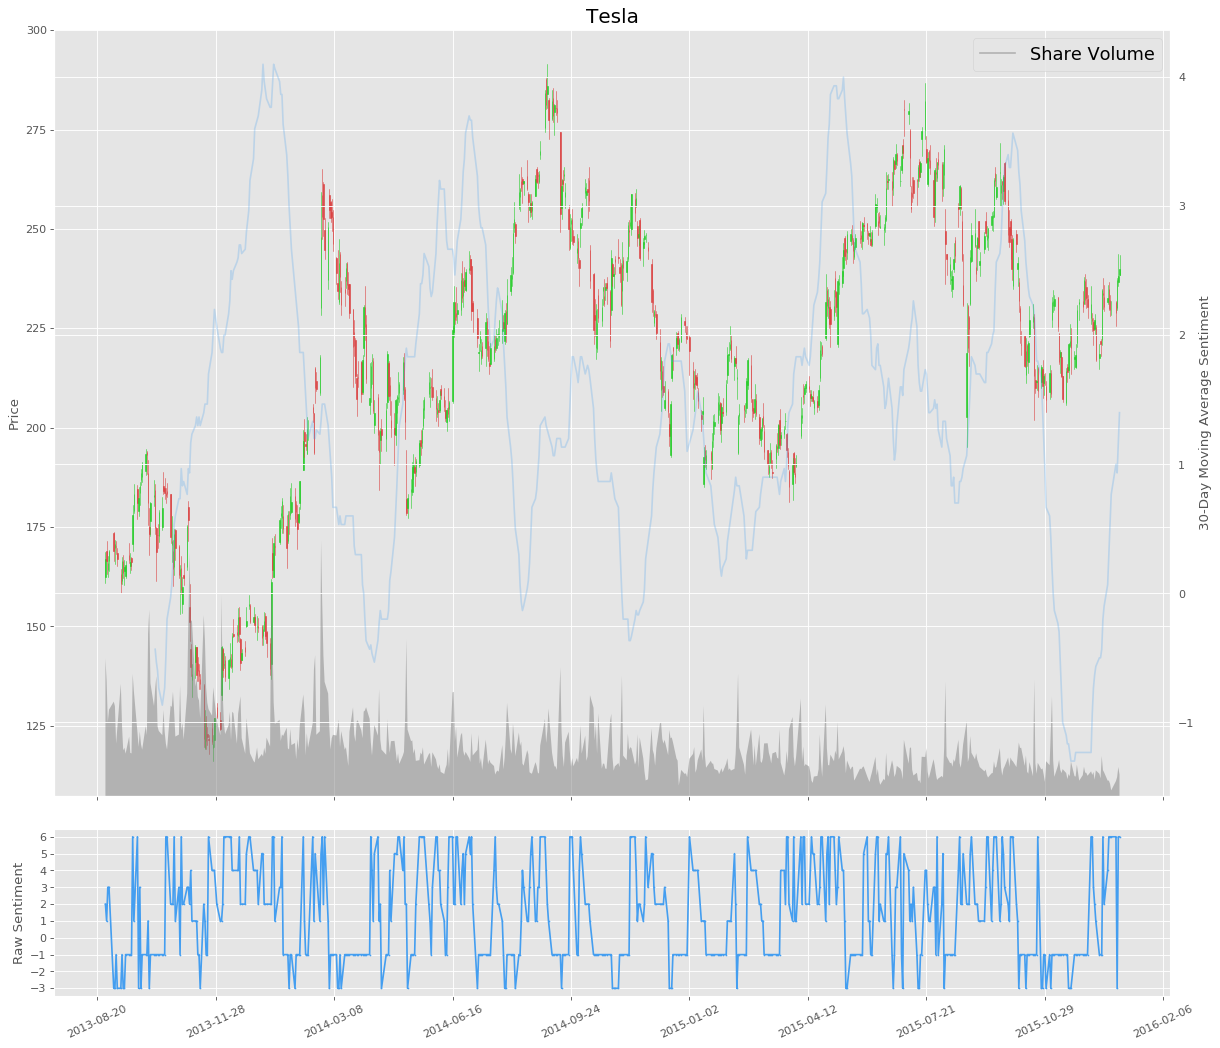

In [108]:
plt.style.use('ggplot')

def candlestick(stock):
	fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

	ax_1 = plt.subplot2grid((5,1), (0,0), rowspan=4, colspan=1)

	plt.title(stock, fontsize=18)
	plt.ylabel('Price')
	ax_1v2 = ax_1.twinx()
	ax_1v3 = ax_1.twinx()
	ax_1v3.yaxis.set_label_position('right')
	plt.ylabel('30-Day Moving Average Sentiment')

	ax_2 = plt.subplot2grid((5,1), (4,0), rowspan=1, colspan=1, sharex= ax_1)
	plt.ylabel('Raw Sentiment')
	df = pickle.load(open('tsla.txt', 'rb'))

	#first graph

	ax_1.tick_params(
		axis = 'y',
		which = 'both',
		right ='off',
		)

	ohlc = []
	for i in range(df.shape[0]):
	    ohlc.append([d.date2num(df.index[i]), df['Open'][i], df['High'][i], df['Low'][i], df['Close'][i]])

	candlestick_ohlc(ax_1, ohlc, width=0.4, colorup='#22cc26', colordown='#db3f3f')



	#second graph
	sent_date = []
	sent_value = []
	for i in range(df.shape[0]):
		sent_date.append(d.date2num(df.index[i]))
		sent_value.append(df['sentiment'][i])
	ax_2.plot(sent_date, sent_value,'s-', color='#449EF0', markersize='0.5')
	ax_2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
	ax_2.xaxis.set_major_locator(mticker.MaxNLocator(10))
	for label in ax_2.xaxis.get_ticklabels():
		label.set_rotation(25)
	ax_2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=10 ,prune='upper'))
	
	#overlapping graph_1
	ax_1v2.tick_params(
		axis = 'y',
		which = 'both',
		right ='off',
		left='off'
		)
	vol =[]
	for i in range(df.shape[0]):
		vol.append(df['Volume'][i])

	vol_date = sent_date
	ax_1v2.plot([],[], color="#808080", alpha=0.5, label="Share Volume")
	ax_1v2.fill_between(vol_date, 0, vol, facecolor="#808080", alpha=0.5)
	ax_1v2.yaxis.set_ticklabels([])
	ax_1v2.grid(False)
	ax_1v2.set_ylim(0, 3*max(vol))


	#overlapping_sent_moving_avg:
	ax_1v3.tick_params(
		axis = 'y',
		which = 'both',
		left='off',
		right = 'off'
		)
	ma = moving_average(sent_value, 30)
	date = sent_date[29:]
	ax_1v3.plot(date, ma, color='#449EF0', alpha=0.25, label="30 Day Moving AVG")

	ax_1v2.legend()
	leg = ax_1v2.legend(prop={'size': 16})
	leg.get_frame()

	plt.setp(ax_1.get_xticklabels(), visible=False)
	plt.show()



def moving_average(values, window):
	weights = np.repeat(1.0, window)/window
	smas = np.convolve(values, weights, 'valid')
	return smas

# df_ = pickle.load(open('amzn_sent.txt', 'rb'))
# df_sent = df_[df_['ticker'] == 'AMZN']['sentiment'][0]
# print(df_sent)
candlestick('Tesla')

Note that Tesla data begins 8 months after the other 4 companies rendering a smaller dataset.

### Random Forest

In [109]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import cross_validation

features = np.asarray(MSFT.drop(['Ticker','Target'], 1))
target = np.asarray(MSFT['Target'])

#feature selection
features_new = SelectKBest(f_classif,k=3).fit_transform(features, target)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
features_new, target, test_size = 0.2, random_state = 0)

from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

range_ = range(2,10)
k_scores = dict()
for k in range_:
    clf = RandomForestClassifier(max_depth = k)
    scores = cross_val_score(clf, features_new, target, cv = 10, scoring = "r2")
    k_scores[scores.mean()] = k

best_k = k_scores[max(k_scores)]


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = best_k)
clf.fit(X_train, y_train)

TSLA_RF = clf.score(X_test, y_test)
TSLA_RF, clf.feature_importances_, features_new

(0.5629139072847682,
 array([ 0.26964854,  0.21042104,  0.51993042]),
 array([[ 0.02601734,  1.        , -0.0870503 ],
        [ 0.00933956, -1.        ,  0.08751946],
        [ 0.00867245,  4.        , -0.29341922],
        ..., 
        [ 0.993996  , -1.        ,  1.26729363],
        [ 1.        ,  6.        ,  0.27806249],
        [ 0.98565711,  4.        , -0.21733126]]))

### Support Vector Machine - rbf kernel

In [110]:
from sklearn import svm
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

range_ = [x/100+0.01 for x in range(1000)]

k_scores = dict()
for k in range_:
    clf_ = svm.SVC(kernel='rbf', C=k)
    scores = cross_val_score(clf_, features_new, target, cv = 3, scoring = "r2")
    k_scores[scores.mean()] = k

best_k = k_scores[max(k_scores)]

clf = svm.SVC(kernel='rbf', C=best_k)
clf.fit(X_train, y_train)
TSLA_SVC_rbf = clf.score(X_test,y_test)
TSLA_SVC_rbf

0.58278145695364236

In [1]:
from bokeh.core.properties import value
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import dodge

output_file("bars.html")

fruits = ['Apple', 'Amazon', 'Google','Microsoft', 'Tesla']
years = ['SVM', 'Random_Forest']

data = {'fruits' : fruits,
        'SVM'   : [0.58, 0.58, 0.52, 0.58, 0.58],
        'Random_Forest'   : [0.58, 0.55, 0.46, 0.60, 0.56]}

# this creates [ ("Apples", "2015"), ("Apples", "2016"), ("Apples", "2017"), ("Pears", "2015), ... ]
source = ColumnDataSource(data=data)

p = figure(x_range=fruits, y_range=(0, 1), plot_height=250, title="Model Accuracy for Stocks",
           toolbar_location=None, tools="")

p.vbar(x=dodge('fruits',  0.0,  range=p.x_range), top='SVM', width=0.2, source=source,
       color="#718dbf", legend=value("SVM"))

p.vbar(x=dodge('fruits',  0.25, range=p.x_range), top='Random_Forest', width=0.2, source=source,
       color="#e84d60", legend=value("Random_Forest"))

p.yaxis.axis_label = "Accuracy"
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

NameError: name 'show' is not defined